In [1]:
!pip install vaderSentiment textblob transformers --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification


In [3]:
# Load datasets
df1 = pd.read_csv('/content/Combined_News_DJIA.csv')
df2 = pd.read_csv('/content/upload_DJIA_table.csv')

# Merge on Date
merge = df1.merge(df2, how='inner', on='Date')

# Combine top25 headlines into single text
headline = [" ".join(str(x) for x in merge.iloc[row, 2:27]) for row in range(len(merge))]
clean_headline = [re.sub("b[(')]", '', text).replace("\\'", '') for text in headline]
merge['Combined_News'] = clean_headline


In [4]:
analyzer = SentimentIntensityAnalyzer()

merge['Sentiment_Compound'] = merge['Combined_News'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
merge['Sentiment_Positive'] = merge['Combined_News'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
merge['Sentiment_Neutral']  = merge['Combined_News'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
merge['Sentiment_Negative'] = merge['Combined_News'].apply(lambda x: analyzer.polarity_scores(x)['neg'])


In [5]:
merge['Polarity'] = merge['Combined_News'].apply(lambda x: TextBlob(x).sentiment.polarity)
merge['Subjectivity'] = merge['Combined_News'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [6]:
# Load FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply FinBERT on headlines
sentiment_labels = []
sentiment_scores = []

for text in merge['Combined_News']:
    res = finbert(text[:512])[0]  # Truncate to 512 tokens
    sentiment_labels.append(res['label'])
    sentiment_scores.append(res['score'])

merge['FinBERT_Label'] = sentiment_labels
merge['FinBERT_Score'] = sentiment_scores


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [7]:
merge['FinBERT_Label_Num'] = merge['FinBERT_Label'].map({'POSITIVE':1, 'NEGATIVE':-1, 'NEUTRAL':0})


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:


# Fill any missing values
merge.fillna(0, inplace=True)

# Feature columns
feature_cols = [
    'Sentiment_Compound', 'Sentiment_Positive', 'Sentiment_Neutral', 'Sentiment_Negative',
    'Polarity', 'Subjectivity',
    'FinBERT_Score', 'FinBERT_Label_Num'
]

# X and y
X = merge[feature_cols]
y = merge['Label']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)


In [12]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [13]:
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)


In [14]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [15]:
def evaluate_model(name, y_true, y_pred, y_prob=None):
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    if y_prob is not None:
        print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [16]:
evaluate_model("Logistic Regression", y_test, y_pred_lr, lr.predict_proba(X_test_scaled)[:,1])



Model: Logistic Regression
Accuracy: 0.5309882747068677
Precision: 0.5352112676056338
Recall: 0.95
F1 Score: 0.6846846846846847
ROC AUC: 0.49247518050541517

Confusion Matrix:
 [[ 13 264]
 [ 16 304]]


In [17]:
evaluate_model("Random Forest", y_test, y_pred_rf, rf.predict_proba(X_test)[:,1])



Model: Random Forest
Accuracy: 0.5058626465661642
Precision: 0.5370919881305638
Recall: 0.565625
F1 Score: 0.5509893455098934
ROC AUC: 0.49688628158844766

Confusion Matrix:
 [[121 156]
 [139 181]]


In [18]:
evaluate_model("SVM", y_test, y_pred_svm, svm.predict_proba(X_test_scaled)[:,1])



Model: SVM
Accuracy: 0.5175879396984925
Precision: 0.5317460317460317
Recall: 0.8375
F1 Score: 0.6504854368932039
ROC AUC: 0.5017148014440433

Confusion Matrix:
 [[ 41 236]
 [ 52 268]]


In [19]:
evaluate_model("XGBoost", y_test, y_pred_xgb, xgb.predict_proba(X_test)[:,1])



Model: XGBoost
Accuracy: 0.5125628140703518
Precision: 0.5403899721448467
Recall: 0.60625
F1 Score: 0.5714285714285714
ROC AUC: 0.49931182310469313

Confusion Matrix:
 [[112 165]
 [126 194]]


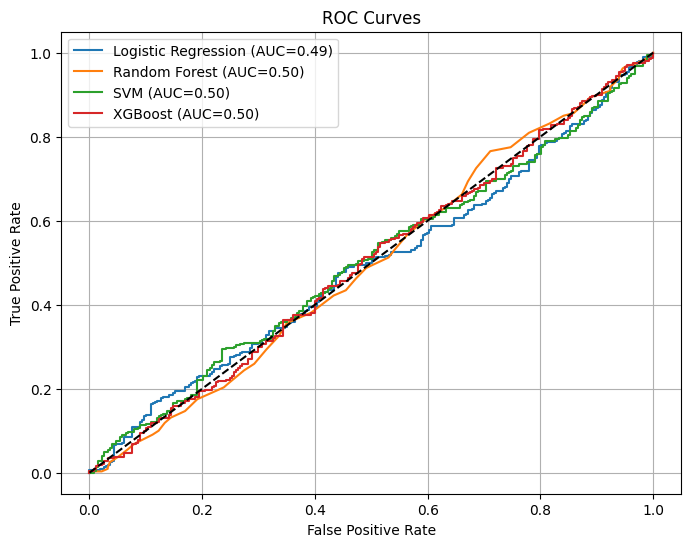

In [20]:
plt.figure(figsize=(8,6))

models = [
    ('Logistic Regression', lr, X_test_scaled),
    ('Random Forest', rf, X_test),
    ('SVM', svm, X_test_scaled),
    ('XGBoost', xgb, X_test)
]

for name, model, data in models:
    y_prob = model.predict_proba(data)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_prob):.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import re
import pandas as pd
from textblob import TextBlob

def real_time_predict_lr(headlines):
    """
    headlines: list of raw news headlines (strings)
    returns: DataFrame with sentiment & prediction
    """
    data = []

    for text in headlines:
        # Clean text: same as before
        clean = re.sub(r'[^\w\s]', '', text.lower())

        # VADER sentiment
        vader_scores = analyzer.polarity_scores(clean)

        # TextBlob
        blob = TextBlob(clean)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # FinBERT
        finbert_res = finbert(text[:512])[0]
        finbert_label = finbert_res['label']
        finbert_score = finbert_res['score']
        finbert_label_num = {'POSITIVE':1, 'NEGATIVE':-1, 'NEUTRAL':0}.get(finbert_label,0)

        # Prepare features (same order as training)
        features = [
            vader_scores['compound'],
            vader_scores['pos'],
            vader_scores['neu'],
            vader_scores['neg'],
            polarity,
            subjectivity,
            finbert_score,
            finbert_label_num
        ]

        # Scale and predict with Logistic Regression
        scaled = scaler.transform([features])
        pred = lr.predict(scaled)[0]
        prob = lr.predict_proba(scaled)[0][1]  # probability of class=1 (market up)

        data.append({
            'Headline': text,
            'VADER_Compound': vader_scores['compound'],
            'TextBlob_Polarity': polarity,
            'FinBERT_Label': finbert_label,
            'Prediction': 'Market Up' if pred==1 else 'Market Down',
            'Risk_Score': round(prob,3)
        })

    return pd.DataFrame(data)


In [24]:
new_headlines = [
    "Federal Reserve announces unexpected interest rate hike",
    "Tech stocks rally as major company reports record profits"
]

result_df = real_time_predict_lr(new_headlines)
print(result_df)


                                            Headline  VADER_Compound  \
0  Federal Reserve announces unexpected interest ...          0.4588   
1  Tech stocks rally as major company reports rec...          0.4404   

   TextBlob_Polarity FinBERT_Label Prediction  Risk_Score  
0             0.1000      negative  Market Up       0.596  
1             0.0625      negative  Market Up       0.629  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
